<a href="https://colab.research.google.com/github/neuroprognosis/CRC-1436-IRTG-Workshop-/blob/main/predictive_modelling_tutorial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CRC 1436 IRTG Technical Workshop - Basics on Predictive Modelling





## A introduction tutorial to fMRI decoding

Here is a simple tutorial on decoding with nilearn. It reproduces the
Haxby 2001 study on a face vs cat discrimination task in a mask of the
ventral stream.

    * J.V. Haxby et al. "Distributed and Overlapping Representations of Faces
      and Objects in Ventral Temporal Cortex", Science vol 293 (2001), p
      2425.-2430.

This tutorial is meant as an introduction to the various steps of a decoding
analysis using Nilearn meta-estimator: :class:`nilearn.decoding.Decoder`

It is not a minimalistic example, as it strives to be didactic. It is not
meant to be copied to analyze new data: many of the steps are unnecessary.
    :depth: 1


### Part 1: Retrieve and load the fMRI data from the Haxby study

#### First download the data

The :func:`nilearn.datasets.fetch_haxby` function will download the
Haxby dataset if not present on the disk, in the nilearn data directory.
It can take a while to download about 310 Mo of data from the Internet.



In [ ]:
!pip install nilearn

     |████████████████████████████████| 10.1 MB 7.1 MB/s 


In [ ]:
from nilearn import datasets
# By default 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby()
# 'func' is a list of filenames: one for each subject
fmri_filename = haxby_dataset.func[0]

# print basic information on the dataset
print('First subject functional nifti images (4D) are at: %s' %fmri_filename)  # 4D data


Dataset created in /root/nilearn_data/haxby2001



 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)


Downloaded 283918336 of 291168628 bytes (97.5%,    0.2s remaining) ...done. (8 seconds, 0 min)
Extracting data from /root/nilearn_data/haxby2001/f33ff337e914bf7fded743c7107979f9/subj2-2010.01.14.tar.gz...

First subject functional nifti images (4D) are at: /root/nilearn_data/haxby2001/subj2/bold.nii.gz


.. done.


#### Visualizing the fmri volume

One way to visualize a :term:`fmri<fMRI>` volume is
using :func:`nilearn.plotting.plot_epi`.
We will visualize the previously fetched :term:`fmri<fMRI>` data from Haxby dataset.

Because :term:`fmri<fMRI>` data are 4D (they consist of many 3D EPI images), we cannot
plot them directly using :func:`nilearn.plotting.plot_epi` (which accepts
just 3D input). Here we are using :func:`nilearn.image.mean_img` to
extract a single 3D EPI image from the :term:`fmri<fMRI>` data.




/usr/local/lib/python3.7/dist-packages/nilearn/plotting/html_stat_map.py:217: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()



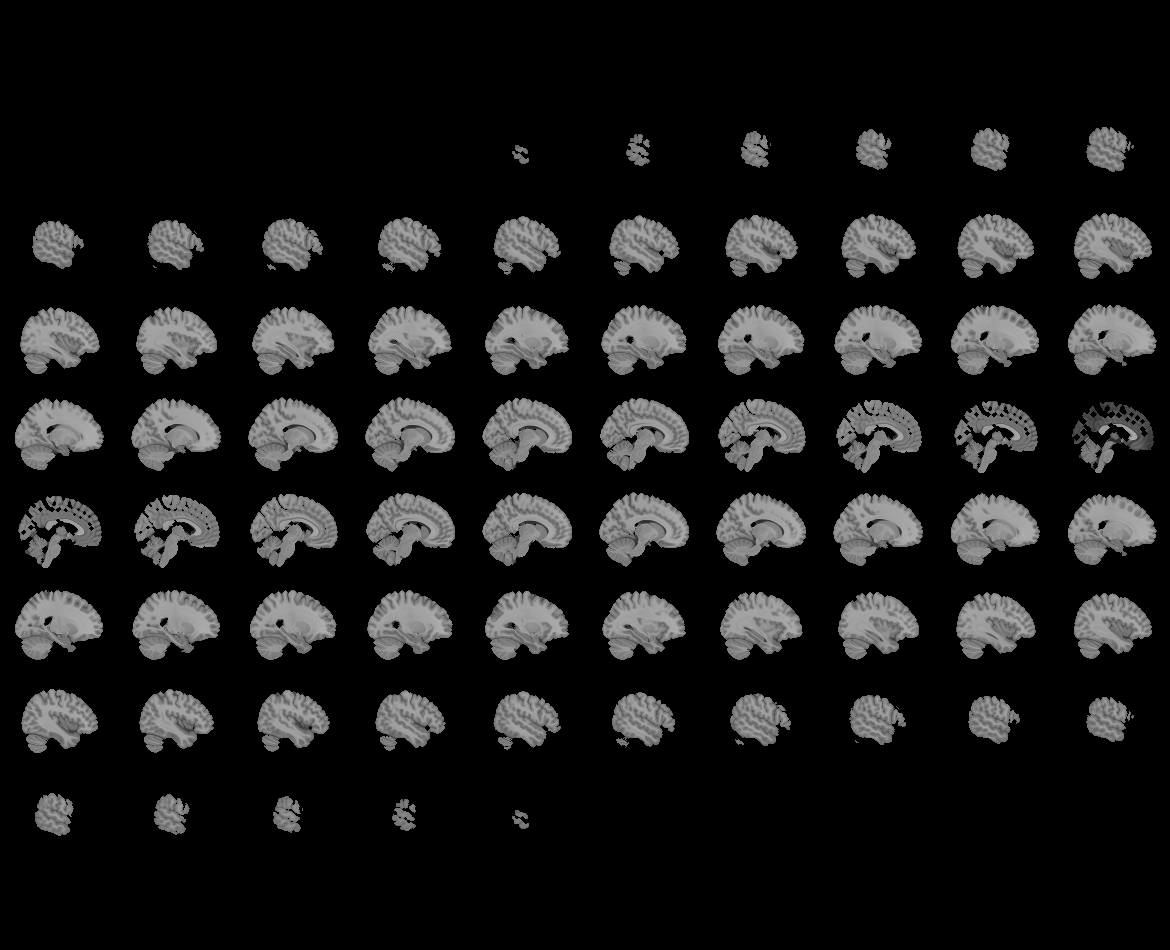
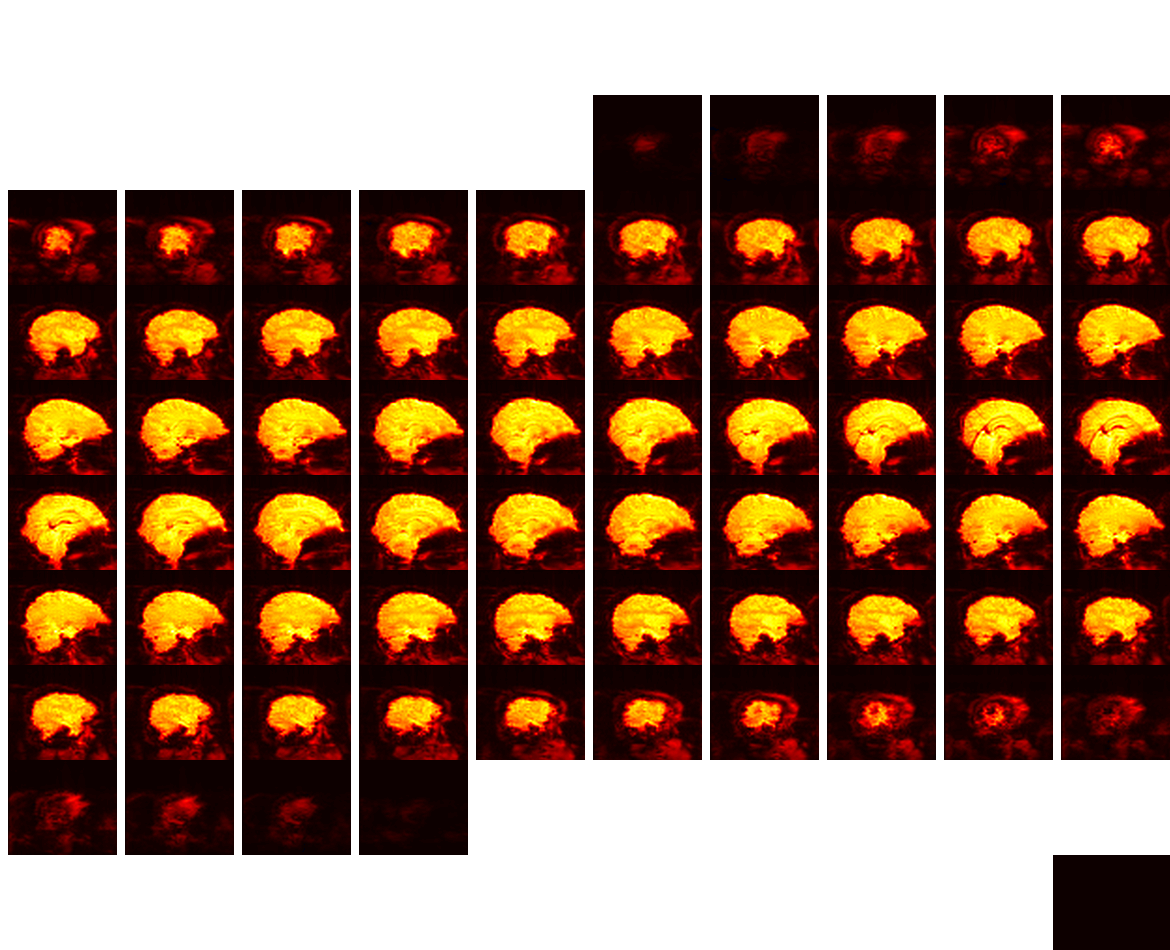

In [ ]:
from nilearn import plotting
from nilearn.image import mean_img
plotting.view_img(mean_img(fmri_filename), threshold=None)

#### Feature extraction: from fMRI volumes to a data matrix

These are some really lovely images, but for machine learning
we need matrices to work with the actual data. Fortunately, the
:class:`nilearn.decoding.Decoder` object we will use later on can
automatically transform Nifti images into matrices.
All we have to do for now is define a mask filename.

A mask of the Ventral Temporal (VT) cortex coming from the
Haxby study is available:



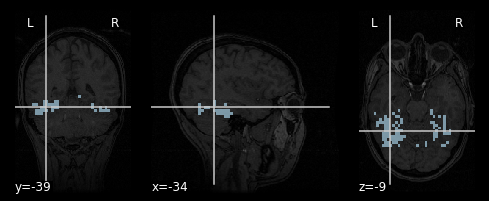

In [ ]:
mask_filename = haxby_dataset.mask_vt[0]

# Let's visualize it, using the subject's anatomical image as a
# background
plotting.plot_roi(mask_filename, bg_img=haxby_dataset.anat[0],
                  cmap='Paired')

#### Load the behavioral labels

Now that the brain images are converted to a data matrix, we can apply
machine-learning to them, for instance to predict the task that the subject
was doing. The behavioral labels are stored in a CSV file, separated by
spaces.

We use pandas to load them in an array.



In [ ]:
import pandas as pd
# Load behavioral information
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
print(behavioral)

     labels  chunks
0      rest       0
1      rest       0
2      rest       0
3      rest       0
4      rest       0
...     ...     ...
1447   rest      11
1448   rest      11
1449   rest      11
1450   rest      11
1451   rest      11

[1452 rows x 2 columns]


The task was a visual-recognition task, and the labels denote the
experimental condition: the type of object that was presented to the
subject. This is what we are going to try to predict.



In [ ]:
conditions = behavioral['labels']
print(conditions)

0       rest
1       rest
2       rest
3       rest
4       rest
        ... 
1447    rest
1448    rest
1449    rest
1450    rest
1451    rest
Name: labels, Length: 1452, dtype: object


#### Restrict the analysis to cats and faces

As we can see from the targets above, the experiment contains many
conditions. As a consequence, the data is quite big. Not all of this data
has an interest to us for decoding, so we will keep only :term:`fmri<fMRI>` signals
corresponding to faces or cats. We create a mask of the samples belonging to
the condition; this mask is then applied to the :term:`fmri<fMRI>` data to restrict the
classification to the face vs cat discrimination.

The input data will become much smaller (i.e. :term:`fmri<fMRI>` signal is shorter):



In [ ]:
condition_mask = conditions.isin(['face', 'cat'])

Because the data is in one single large 4D image, we need to use
index_img to do the split easily.



In [ ]:
from nilearn.image import index_img
fmri_niimgs = index_img(fmri_filename, condition_mask)

We apply the same mask to the targets



In [ ]:
conditions = conditions[condition_mask]
# Convert to numpy array
conditions = conditions.values
print(conditions.shape)

(216,)


### Part 2: Decoding with Support Vector Machine

As a decoder, we use a Support Vector Classifier with a linear kernel. We
first create it using by using :class:`nilearn.decoding.Decoder`.



In [ ]:
from nilearn.decoding import Decoder
decoder = Decoder(estimator='svc', mask=mask_filename, standardize=True)

The decoder object is an object that can be fit (or trained) on data with
labels, and then predict labels on data without.

We first fit it on the data



In [ ]:
decoder.fit(fmri_niimgs, conditions)

We can then predict the labels from the data



In [ ]:
prediction = decoder.predict(fmri_niimgs)
print(prediction)

['face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'face' 'face' 'face' 'face' 'face' 'face' 'face' '

Note that for this classification task both classes contain the same number
of samples (the problem is balanced). Then, we can use accuracy to measure
the performance of the decoder. This is done by defining accuracy as the
`scoring`.
Let's measure the prediction accuracy:



In [ ]:
print((prediction == conditions).sum() / float(len(conditions)))

1.0


This prediction accuracy score is meaningless. Why?



### Part 3: Measuring prediction scores using cross-validation

The proper way to measure error rates or prediction accuracy is via
cross-validation: leaving out some data and testing on it.

### Manually leaving out data

Let's leave out the 30 last data points during training, and test the
prediction on these 30 last points:



In [ ]:
fmri_niimgs_train = index_img(fmri_niimgs, slice(0, -30))
fmri_niimgs_test = index_img(fmri_niimgs, slice(-30, None))
conditions_train = conditions[:-30]
conditions_test = conditions[-30:]

decoder = Decoder(estimator='svc', mask=mask_filename, standardize=True)
decoder.fit(fmri_niimgs_train, conditions_train)

prediction = decoder.predict(fmri_niimgs_test)

# The prediction accuracy is calculated on the test data: this is the accuracy
# of our model on examples it hasn't seen to examine how well the model perform
# in general.

print("Prediction Accuracy: {:.3f}".format(
    (prediction == conditions_test).sum() / float(len(conditions_test))))

Prediction Accuracy: 0.767


#### Implementing a KFold loop

We can manually split the data in train and test set repetitively in a
`KFold` strategy by importing scikit-learn's object:



In [ ]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5)

# The "cv" object's split method can now accept data and create a
# generator which can yield the splits.
fold = 0
for train, test in cv.split(conditions):
    fold += 1
    decoder = Decoder(estimator='svc', mask=mask_filename, standardize=True)
    decoder.fit(index_img(fmri_niimgs, train), conditions[train])
    prediction = decoder.predict(index_img(fmri_niimgs, test))
    print(
        "CV Fold {:01d} | Prediction Accuracy: {:.3f}".format(
            fold,
            (prediction == conditions[test]).sum() / float(len(
                conditions[test]))))

CV Fold 1 | Prediction Accuracy: 0.886
CV Fold 2 | Prediction Accuracy: 0.767
CV Fold 3 | Prediction Accuracy: 0.767
CV Fold 4 | Prediction Accuracy: 0.698
CV Fold 5 | Prediction Accuracy: 0.744


#### Cross-validation with the decoder

The decoder also implements a cross-validation loop by default and returns
an array of shape (cross-validation parameters, `n_folds`). We can use
accuracy score to measure its performance by defining `accuracy` as the
`scoring` parameter.



In [ ]:
n_folds = 5
decoder = Decoder(
    estimator='svc', mask=mask_filename,
    standardize=True, cv=n_folds,
    scoring='accuracy'
)
decoder.fit(fmri_niimgs, conditions)

Cross-validation pipeline can also be implemented manually. More details can
be found on `scikit-learn website
<https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html>`_.

Then we can check the best performing parameters per fold.



In [ ]:
print(decoder.cv_params_['face'])

{'C': [100.0, 100.0, 100.0, 100.0, 100.0]}


<div class="alert alert-info"><h4>Note</h4><p></p></div>
	We can speed things up to use all the CPUs of our computer with the
	n_jobs parameter.

The best way to do cross-validation is to respect the structure of
the experiment, for instance by leaving out full sessions of
acquisition.

The number of the session is stored in the CSV file giving the
behavioral data. We have to apply our session mask, to select only cats
and faces.



In [ ]:
session_label = behavioral['chunks'][condition_mask]

The :term:`fMRI` data is acquired by sessions, and the noise is autocorrelated in a
given session. Hence, it is better to predict across sessions when doing
cross-validation. To leave a session out, pass the cross-validator object
to the cv parameter of decoder.



In [ ]:
from sklearn.model_selection import LeaveOneGroupOut
cv = LeaveOneGroupOut()

decoder = Decoder(estimator='svc', mask=mask_filename, standardize=True,
                  cv=cv)
decoder.fit(fmri_niimgs, conditions, groups=session_label)

print(decoder.cv_scores_)

{'cat': [1.0, 1.0, 1.0, 1.0, 0.9629629629629629, 0.8518518518518519, 0.9753086419753086, 0.40740740740740744, 0.9876543209876543, 1.0, 0.9259259259259259, 0.8765432098765432], 'face': [1.0, 1.0, 1.0, 1.0, 0.9629629629629629, 0.8518518518518519, 0.9753086419753086, 0.40740740740740744, 0.9876543209876543, 1.0, 0.9259259259259259, 0.8765432098765432]}


### Part 4: Inspecting the model weights

Finally, it may be useful to inspect and display the model weights.

### Turning the weights into a nifti image

We retrieve the SVC discriminating weights



In [ ]:
coef_ = decoder.coef_
print(coef_)

[[-3.88469528e-02 -1.86752036e-02 -3.22274234e-02 -2.88104756e-02
   4.17749132e-02  1.10473263e-02  1.69629485e-02 -5.49689493e-02
  -1.93773568e-02 -3.50419030e-02  1.08277891e-02 -1.28501273e-02
  -1.54318352e-02 -3.78043866e-02 -3.68279819e-02  2.27557791e-02
   6.55002768e-03 -7.64050898e-03  1.66730503e-02 -8.00446692e-03
   5.28261837e-02 -8.15726780e-02 -6.35573249e-02  2.40756250e-02
   4.58824935e-02 -2.22075763e-02 -1.76882123e-02  2.21690185e-02
  -9.51044877e-03  5.74706825e-02  2.13814402e-02 -9.12117785e-02
   4.02841728e-03 -2.88624042e-02 -3.88124474e-02 -3.34318256e-02
   2.20842930e-03  8.71165083e-03 -3.36653200e-02 -2.40701832e-02
  -6.80080963e-02  1.65045838e-02  2.70137946e-02 -6.55157808e-03
  -1.21381483e-02  5.46412488e-02  8.11530838e-03  3.60125763e-02
  -1.52386880e-02  7.01266273e-02  1.28214436e-03  2.07520967e-02
  -4.09188425e-03  3.71551560e-02 -3.76545942e-02 -1.03610101e-02
  -2.37698762e-02 -5.47604538e-02  4.41999332e-02 -1.47077149e-01
  -2.33519

It's a numpy array with only one coefficient per voxel:



In [ ]:
print(coef_.shape)

(1, 464)


To get the Nifti image of these coefficients, we only need retrieve the
`coef_img_` in the decoder and select the class



In [ ]:
coef_img = decoder.coef_img_['face']

coef_img is now a NiftiImage.  We can save the coefficients as a nii.gz file:



In [ ]:
decoder.coef_img_['face'].to_filename('haxby_svc_weights.nii.gz')

#### Plotting the SVM weights

We can plot the weights, using the subject's anatomical as a background




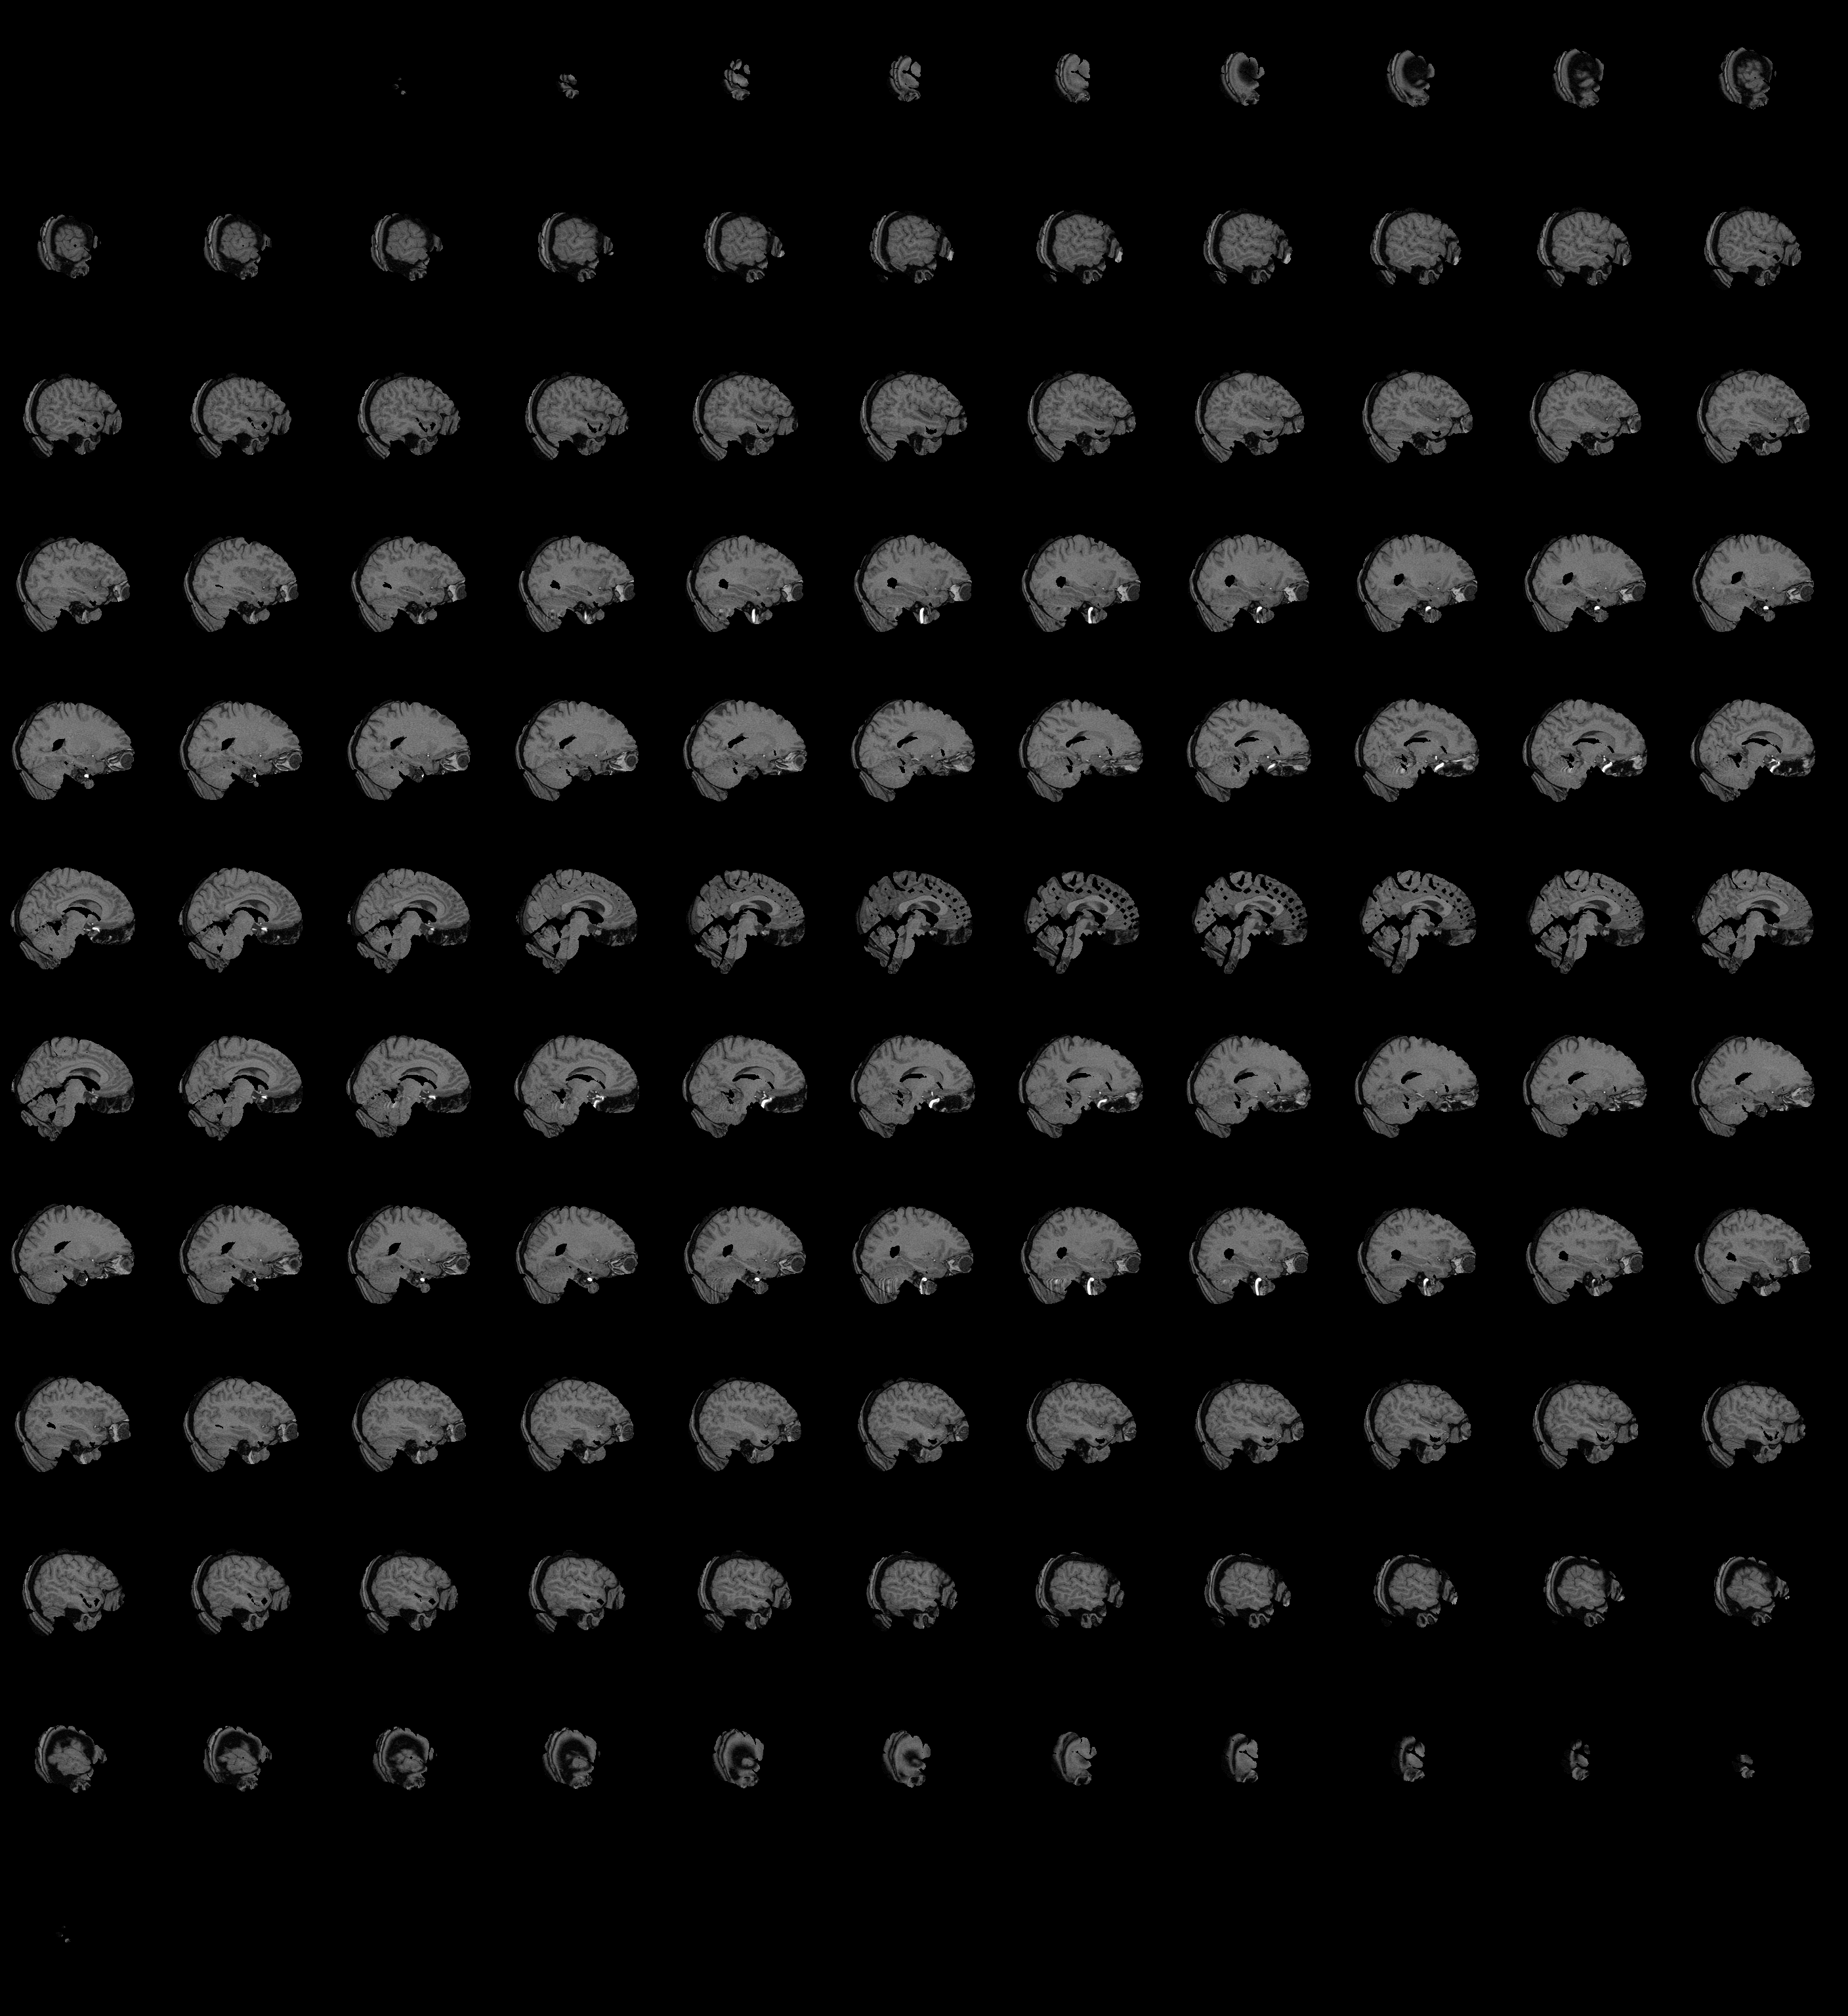
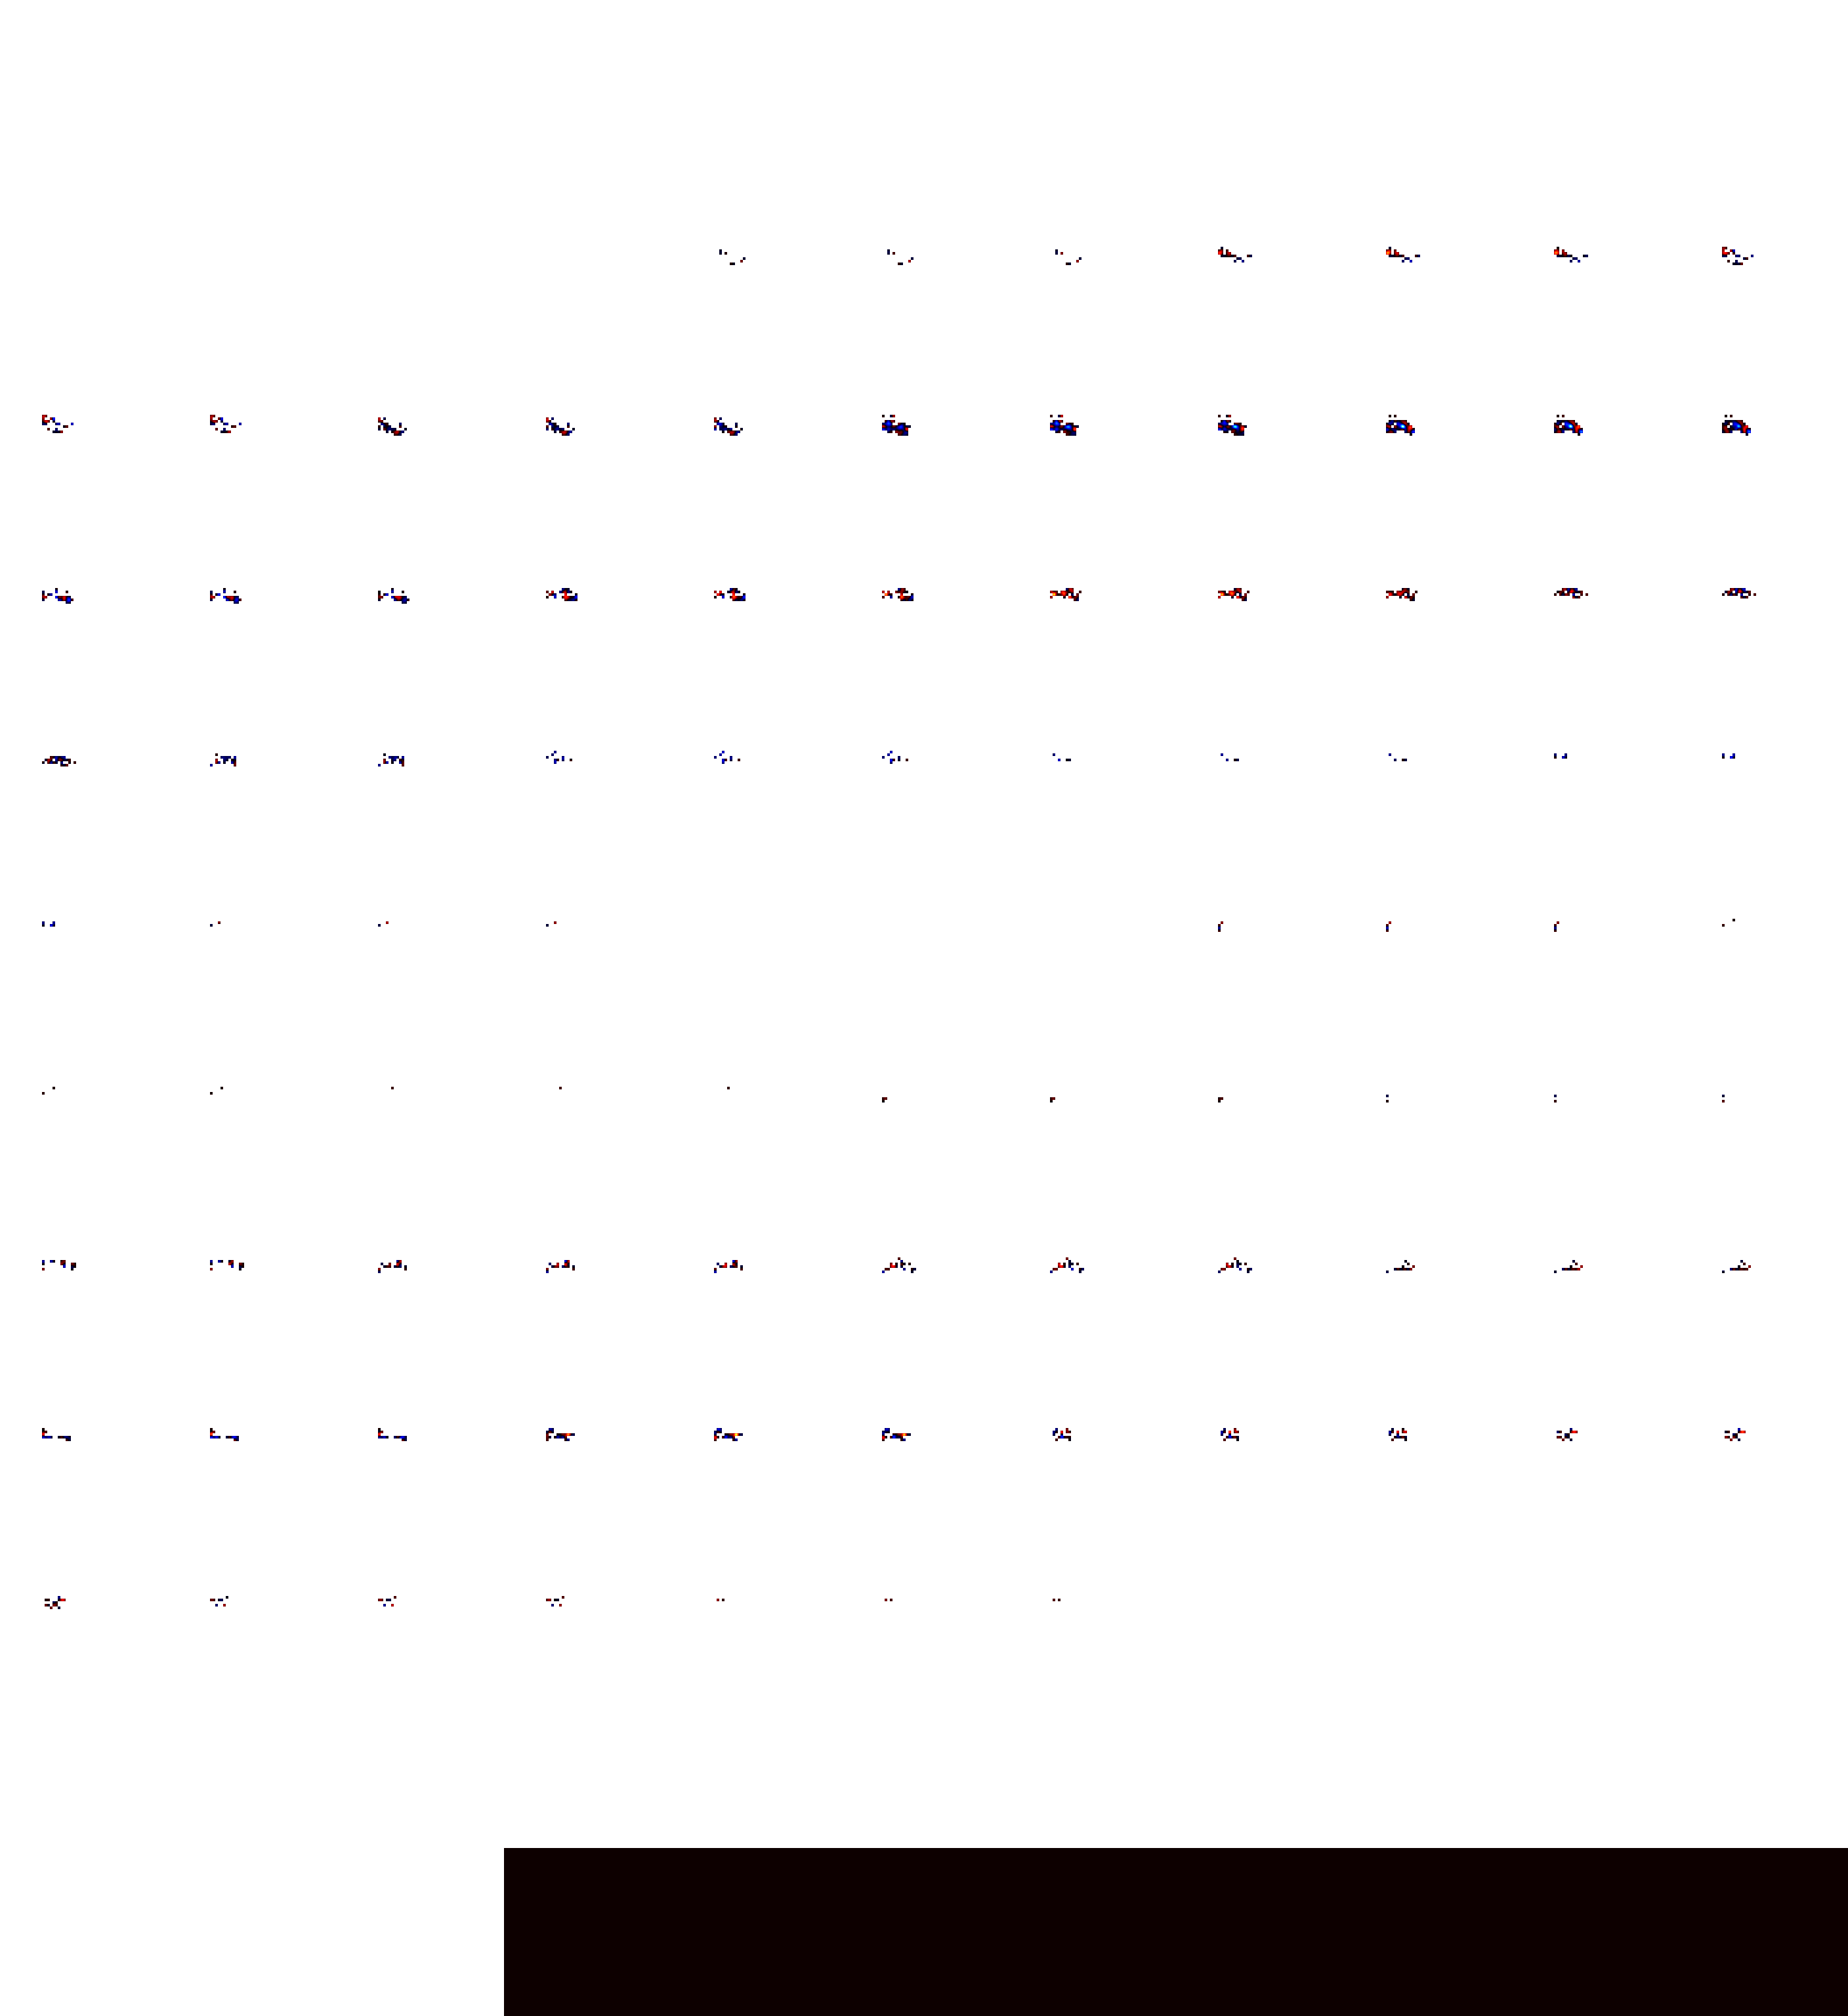

In [ ]:
plotting.view_img(
    decoder.coef_img_['face'], bg_img=haxby_dataset.anat[0],
    title="SVM weights", dim=-1
)

### What is the chance level accuracy?

Does the model above perform better than chance?
To answer this question, we measure a score at random using simple strategies
that are implemented in the :class:`nilearn.decoding.Decoder` object. This is
useful to inspect the decoding performance by comparing to a score at chance.



Let's define a object with Dummy estimator replacing 'svc' for classification
setting. This object initializes estimator with default dummy strategy.



In [ ]:
dummy_decoder = Decoder(estimator='dummy_classifier', mask=mask_filename,
                        cv=cv)
dummy_decoder.fit(fmri_niimgs, conditions, groups=session_label)

# Now, we can compare these scores by simply taking a mean over folds
print(dummy_decoder.cv_scores_)

{'cat': [0.38888888888888895, 0.38888888888888895, 0.38888888888888895, 0.6111111111111112, 0.38888888888888895, 0.6111111111111112, 0.38888888888888895, 0.38888888888888895, 0.38888888888888895, 0.38888888888888895, 0.6111111111111112, 0.38888888888888895], 'face': [0.38888888888888895, 0.38888888888888895, 0.38888888888888895, 0.6111111111111112, 0.38888888888888895, 0.6111111111111112, 0.38888888888888895, 0.38888888888888895, 0.38888888888888895, 0.38888888888888895, 0.6111111111111112, 0.38888888888888895]}
